## DL PROJECT

## Task 1: Baseline Evaluation

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import json
import os
import zipfile

In [2]:
from google.colab import files
uploaded = files.upload()

Saving TestDataSet.zip to TestDataSet.zip


In [3]:
zip_path = "/content/TestDataSet.zip"
extract_path = "/content/TestDataSet"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

['TestDataSet', '__MACOSX']

In [4]:
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset_path = "/content/TestDataSet/TestDataSet"


with open(os.path.join(dataset_path, "labels_list.json"), 'r') as f:
    label_lines = json.load(f)


imagenet_labels = [int(line.split(":")[0]) for line in label_lines]


image_folder_dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)


idx_to_imagenet = {i: imagenet_labels[i] for i in range(len(imagenet_labels))}


class CorrectedLabelDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, idx_to_imagenet_label):
        self.base_dataset = base_dataset
        self.idx_to_imagenet_label = idx_to_imagenet_label

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, folder_idx = self.base_dataset[idx]
        true_label = self.idx_to_imagenet_label[folder_idx]
        return image, int(true_label)


corrected_dataset = CorrectedLabelDataset(image_folder_dataset, idx_to_imagenet)
test_loader = DataLoader(corrected_dataset, batch_size=32, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()


def topk_accuracy(output, target, topk=(1, 5)):
    maxk = max(topk)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.item())
    return res


top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        top1, top5 = topk_accuracy(outputs, labels, topk=(1, 5))
        top1_correct += top1
        top5_correct += top5
        total += labels.size(0)

print(f"\nResults for Task 1:")
print(f"Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"Top-5 Accuracy: {100 * top5_correct / total:.2f}%")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 194MB/s]
100%|██████████| 16/16 [00:02<00:00,  6.05it/s]


Results for Task 1:
Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


In [5]:
with open(os.path.join(dataset_path, "labels_list.json"), 'r') as f:
    label_list = json.load(f)

print(label_list[:5])

['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship']


## Task 2

In [11]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
import json


epsilon = 0.02
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])


mean_tensor = torch.tensor(mean_norms, dtype=torch.float32).view(3, 1, 1).to(device)
std_tensor = torch.tensor(std_norms, dtype=torch.float32).view(3, 1, 1).to(device)


def unnormalize(img):
    return img * std_tensor + mean_tensor

def normalize(img):
    return (img - mean_tensor) / std_tensor


def rfsgm_attack_pixel_space(image, epsilon, model, label):
    pixel_img = unnormalize(image)
    perturbed = pixel_img + torch.empty_like(pixel_img).uniform_(-epsilon, epsilon)
    perturbed = perturbed.detach().clone().requires_grad_(True)

    output = model(normalize(perturbed))
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()

    grad = perturbed.grad.data
    adv_pixel = perturbed + epsilon * grad.sign()
    adv_pixel = torch.clamp(adv_pixel, 0, 1)
    return normalize(adv_pixel)


plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])


dataset_path = "/content/TestDataSet/TestDataSet"
labels_json = "/content/TestDataSet/TestDataSet/labels_list.json"


with open(labels_json, 'r') as f:
    label_lines = json.load(f)

imagenet_labels = [int(line.split(":")[0]) for line in label_lines]
idx_to_imagenet = {i: imagenet_labels[i] for i in range(len(imagenet_labels))}


image_folder_dataset = ImageFolder(root=dataset_path, transform=plain_transforms)

class CorrectedLabelDataset(Dataset):
    def __init__(self, base_dataset, idx_to_imagenet_label):
        self.base_dataset = base_dataset
        self.idx_to_imagenet_label = idx_to_imagenet_label
    def __len__(self):
        return len(self.base_dataset)
    def __getitem__(self, idx):
        image, folder_idx = self.base_dataset[idx]
        label = self.idx_to_imagenet_label[folder_idx]
        return image, label

corrected_dataset = CorrectedLabelDataset(image_folder_dataset, idx_to_imagenet)
test_loader = DataLoader(corrected_dataset, batch_size=1, shuffle=False)


model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()


adv_images = []
adv_labels = []

top1_correct = 0
top5_correct = 0
total = 0

for image, label in test_loader:
    image, label = image.to(device), label.to(device)


    perturbed_data = rfsgm_attack_pixel_space(image, epsilon, model, label)


    adv_images.append(perturbed_data.detach().cpu())
    adv_labels.append(label.detach().cpu())


    output = model(perturbed_data)
    _, top5 = output.topk(5, 1, True, True)
    top1 = top5[:, 0]

    top1_correct += (top1 == label).sum().item()
    top5_correct += sum([label.item() in top5[i] for i in range(len(label))])
    total += label.size(0)

print(f"\nResults for Task 2:")
print(f"Adversarial FGSM Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"Adversarial FGSM Top-5 Accuracy: {100 * top5_correct / total:.2f}%")



Results for Task 2:
Adversarial FGSM Top-1 Accuracy: 1.40%
Adversarial FGSM Top-5 Accuracy: 15.80%


In [12]:
import torchvision.utils
from pathlib import Path


save_dir = Path("/content/AdversarialTestSet1")
save_dir.mkdir(parents=True, exist_ok=True)


for i, adv_img in enumerate(adv_images):
    img = adv_img.squeeze(0)

    pixel_img = img * torch.tensor(std_norms).view(3,1,1) + torch.tensor(mean_norms).view(3,1,1)
    pixel_img = torch.clamp(pixel_img, 0, 1)
    torchvision.utils.save_image(pixel_img, save_dir / f"adv_{i:04d}.png")


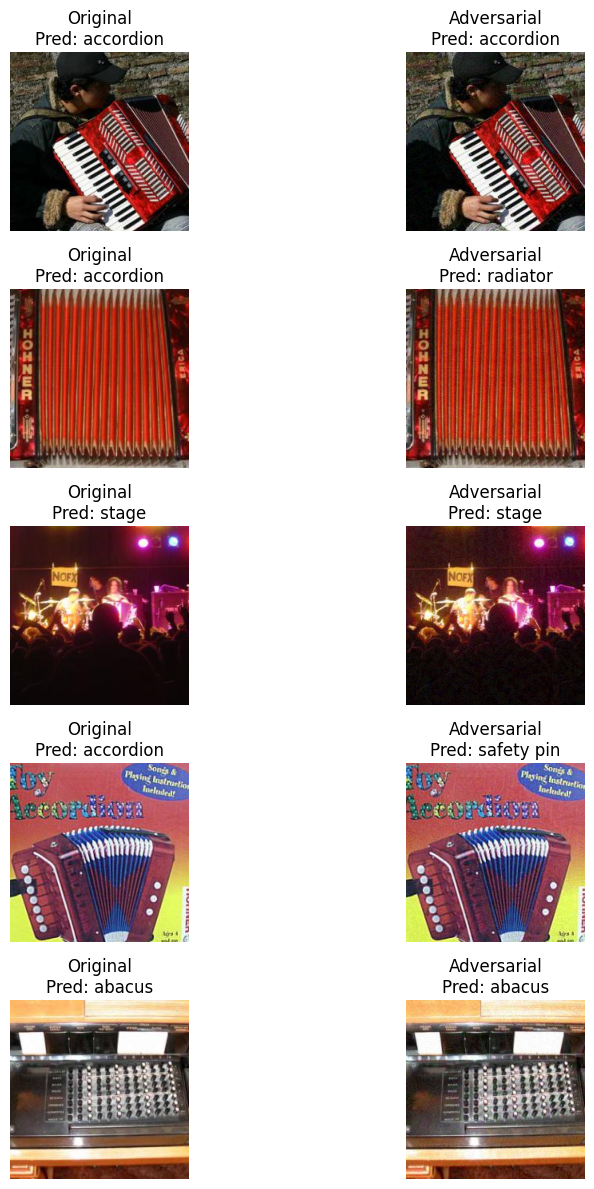

In [16]:
import matplotlib.pyplot as plt
from torchvision.models import resnet34, ResNet34_Weights


weights = ResNet34_Weights.IMAGENET1K_V1
imagenet_class_index = weights.meta["categories"]

model = resnet34(weights=weights).to(device)
model.eval()


def get_topk_labels(output, k=5):
    _, indices = output.topk(k, 1, True, True)
    return indices[0].tolist()


fig, axes = plt.subplots(5, 2, figsize=(10, 12))

for i in range(5):

    orig_img, true_label = corrected_dataset[i]
    orig_img = orig_img.unsqueeze(0).to(device)


    adv_img = rfsgm_attack_pixel_space(orig_img, epsilon, model, torch.tensor([true_label]).to(device))


    orig_disp = unnormalize(orig_img[0]).detach().cpu().permute(1, 2, 0).numpy()
    adv_disp = unnormalize(adv_img[0]).detach().cpu().permute(1, 2, 0).numpy()


    with torch.no_grad():
        orig_pred = model(orig_img)
        adv_pred = model(adv_img)

    orig_top = get_topk_labels(orig_pred, k=1)[0]
    adv_top = get_topk_labels(adv_pred, k=1)[0]


    axes[i, 0].imshow(np.clip(orig_disp, 0, 1))
    axes[i, 0].set_title(f"Original\nPred: {imagenet_class_index[orig_top]}")
    axes[i, 1].imshow(np.clip(adv_disp, 0, 1))
    axes[i, 1].set_title(f"Adversarial\nPred: {imagenet_class_index[adv_top]}")
    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()


## Task 3

In [18]:
def pgd_attack_pixel_space(image, label, model, epsilon=0.02, alpha=0.005, num_iter=10):
    original = unnormalize(image).detach()
    perturbed = original + torch.empty_like(original).uniform_(-epsilon, epsilon)
    perturbed = torch.clamp(perturbed, 0, 1).detach().clone().requires_grad_(True)

    for _ in range(num_iter):
        output = model(normalize(perturbed))
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()


        grad = perturbed.grad.data
        perturbed = perturbed + alpha * grad.sign()

        perturbation = torch.clamp(perturbed - original, -epsilon, epsilon)
        perturbed = torch.clamp(original + perturbation, 0, 1).detach().requires_grad_(True)

    return normalize(perturbed)


In [19]:
adv_images_task3 = []
adv_labels_task3 = []

top1_correct = 0
top5_correct = 0
total = 0

for image, label in test_loader:
    image, label = image.to(device), label.to(device)

    adv_img = pgd_attack_pixel_space(image, label, model, epsilon=0.02, alpha=0.005, num_iter=10)

    adv_images_task3.append(adv_img.detach().cpu())
    adv_labels_task3.append(label.detach().cpu())

    with torch.no_grad():
        output = model(adv_img)
        _, top5 = output.topk(5, 1, True, True)
        top1 = top5[:, 0]

    top1_correct += (top1 == label).sum().item()
    top5_correct += sum([label.item() in top5[i] for i in range(len(label))])
    total += label.size(0)

print(f"\nResults for Task 3:")
print(f"Adversarial PGD Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"Adversarial PGD Top-5 Accuracy: {100 * top5_correct / total:.2f}%")



Results for Task 3:
Adversarial PGD Top-1 Accuracy: 0.00%
Adversarial PGD Top-5 Accuracy: 1.40%


In [21]:
import torchvision.utils
from pathlib import Path


save_dir = Path("/content/AdversarialTestSet2")
save_dir.mkdir(parents=True, exist_ok=True)


for i, img in enumerate(adv_images_task3):

    img = img.to(mean_tensor.device)
    unnorm = unnormalize(img[0])
    torchvision.utils.save_image(unnorm, save_dir / f"adv_{i:04d}.png")



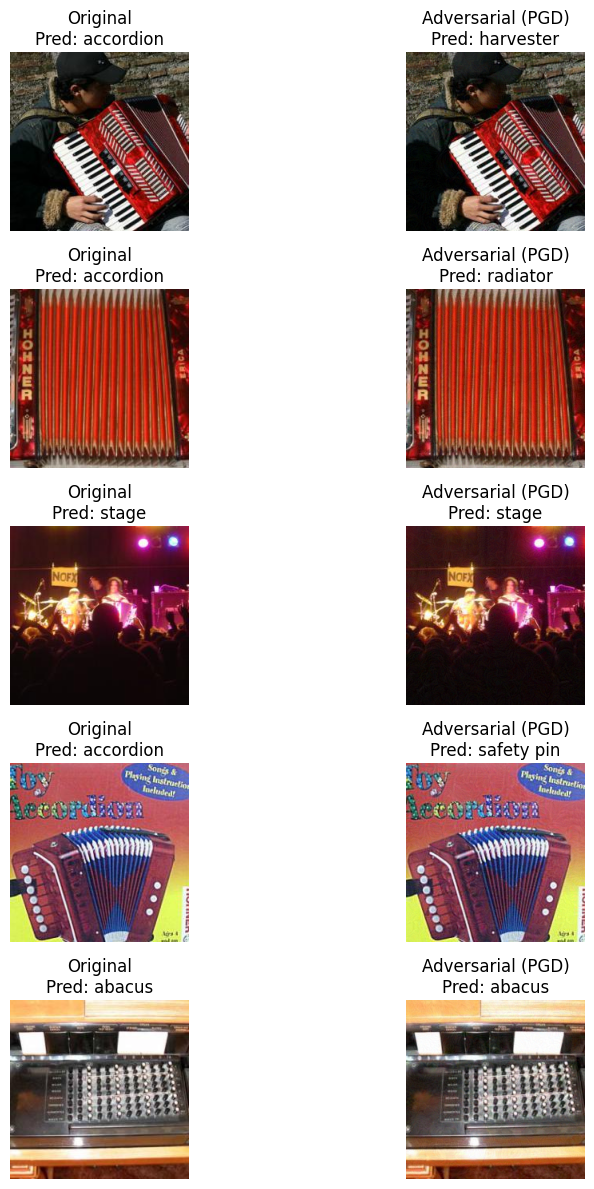

In [22]:
from torchvision.models import resnet34, ResNet34_Weights


weights = ResNet34_Weights.IMAGENET1K_V1
imagenet_class_index = weights.meta["categories"]


def get_topk_labels(output, k=5):
    _, indices = output.topk(k, 1, True, True)
    return indices[0].tolist()


fig, axes = plt.subplots(5, 2, figsize=(10, 12))

for i in range(5):
    orig_img, true_label = corrected_dataset[i]
    orig_img = orig_img.unsqueeze(0).to(device)


    adv_img = pgd_attack_pixel_space(orig_img, torch.tensor([true_label]).to(device), model)


    img_gpu = orig_img[0].to(mean_tensor.device)
    adv_gpu = adv_img[0].to(mean_tensor.device)


    orig_disp = unnormalize(img_gpu).detach().cpu().permute(1, 2, 0).numpy()
    adv_disp = unnormalize(adv_gpu).detach().cpu().permute(1, 2, 0).numpy()


    with torch.no_grad():
        orig_pred = model(orig_img)
        adv_pred = model(adv_img)

    orig_top = get_topk_labels(orig_pred, k=1)[0]
    adv_top = get_topk_labels(adv_pred, k=1)[0]


    axes[i, 0].imshow(np.clip(orig_disp, 0, 1))
    axes[i, 0].set_title(f"Original\nPred: {imagenet_class_index[orig_top]}")
    axes[i, 1].imshow(np.clip(adv_disp, 0, 1))
    axes[i, 1].set_title(f"Adversarial (PGD)\nPred: {imagenet_class_index[adv_top]}")
    for ax in axes[i]: ax.axis("off")

plt.tight_layout()
plt.show()


## Task 4

In [39]:
def pgd_patch_attack_multilocation(
    image,
    label,
    model,
    epsilon=0.5,
    alpha=0.01,
    num_iter=60,
    patch_size=32,
    target_class=879
):
    original = unnormalize(image).detach()
    perturbed = original.clone().detach()
    _, _, H, W = perturbed.shape

    locations = [
        ((H - patch_size) // 2, (W - patch_size) // 2),
        (H - patch_size - 1, W - patch_size - 1),
        (0, 0)
    ]

    for _ in range(num_iter):
        perturbed.requires_grad_(True)
        output = model(normalize(perturbed))


        target = torch.tensor([target_class], dtype=torch.long).to(label.device)
        loss = -F.cross_entropy(output, target)

        model.zero_grad()
        loss.backward()

        grad = perturbed.grad.data
        patch_grad = torch.zeros_like(grad)

        for (top, left) in locations:
            patch_grad[:, :, top:top+patch_size, left:left+patch_size] += grad[:, :, top:top+patch_size, left:left+patch_size]

        perturbed = perturbed + alpha * patch_grad.sign()


        perturbation = torch.clamp(perturbed - original, min=-epsilon, max=epsilon)
        perturbed = torch.clamp(original + perturbation, 0, 1).detach()

    return normalize(perturbed)


In [40]:
adv_images_task4 = []
adv_labels_task4 = []

top1_correct = 0
top5_correct = 0
total = 0

for image, label in test_loader:
    image, label = image.to(device), label.to(device)

    adv_img = pgd_patch_attack_multilocation(
        image=image,
        label=label,
        model=model,
        epsilon=0.5,
        alpha=0.01,
        num_iter=60,
        patch_size=32,
        target_class=879
    )

    adv_images_task4.append(adv_img.detach().cpu())
    adv_labels_task4.append(label.detach().cpu())

    with torch.no_grad():
        output = model(adv_img)
        _, top5 = output.topk(5, 1, True, True)
        top1 = top5[:, 0]

    top1_correct += (top1 == label).sum().item()
    top5_correct += sum([label.item() in top5[i] for i in range(len(label))])
    total += label.size(0)


print(f"\nResults for Task 4 (Multi-Location):")
print(f"Adversarial Patch Attack Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"Adversarial Patch Attack Top-5 Accuracy: {100 * top5_correct / total:.2f}%")



Results for Task 4 (Multi-Location):
Adversarial Patch Attack Top-1 Accuracy: 1.40%
Adversarial Patch Attack Top-5 Accuracy: 42.20%


In [41]:
import torchvision.utils
from pathlib import Path


save_dir = Path("/content/AdversarialTestSet3")
save_dir.mkdir(parents=True, exist_ok=True)


for i, img in enumerate(adv_images_task4):
    img = img.to(mean_tensor.device)
    unnorm = unnormalize(img[0])
    torchvision.utils.save_image(unnorm, save_dir / f"adv_{i:04d}.png")


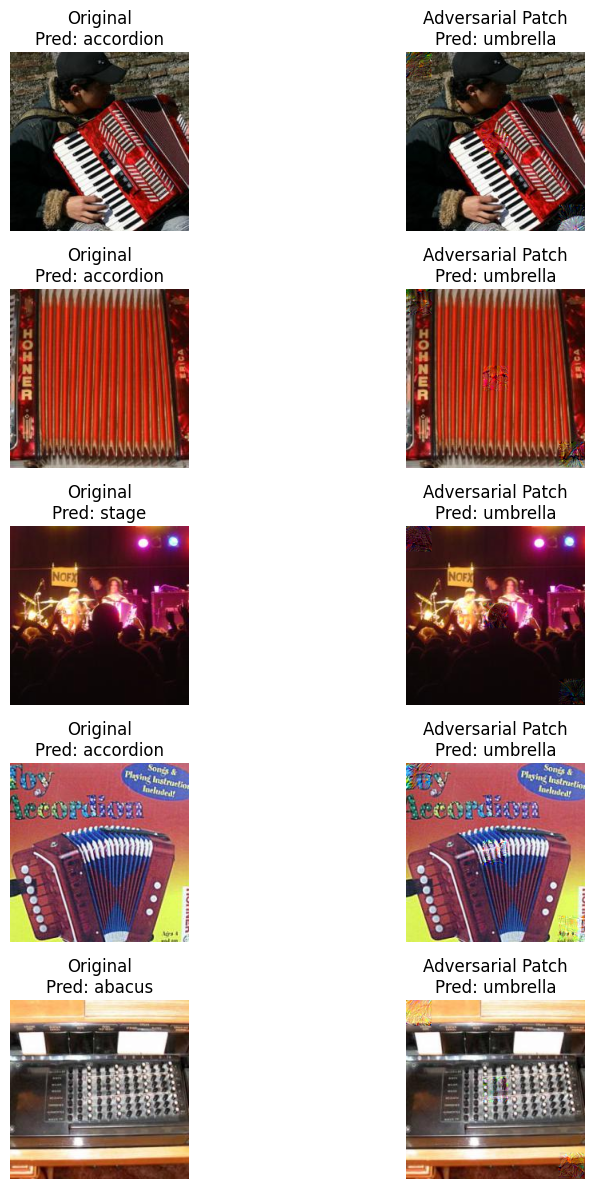

In [42]:
fig, axes = plt.subplots(5, 2, figsize=(10, 12))

for i in range(5):
    orig_img, true_label = corrected_dataset[i]
    orig_img = orig_img.unsqueeze(0).to(device)


    adv_img = pgd_patch_attack_multilocation(
        image=orig_img,
        label=torch.tensor([true_label]).to(device),
        model=model,
        epsilon=0.5,
        alpha=0.01,
        num_iter=60,
        patch_size=32,
        target_class=879
    )


    orig_disp = unnormalize(orig_img[0].to(mean_tensor.device)).detach().cpu().permute(1, 2, 0).numpy()
    adv_disp = unnormalize(adv_img[0].to(mean_tensor.device)).detach().cpu().permute(1, 2, 0).numpy()


    with torch.no_grad():
        orig_pred = model(orig_img)
        adv_pred = model(adv_img)

    orig_top = get_topk_labels(orig_pred, k=1)[0]
    adv_top = get_topk_labels(adv_pred, k=1)[0]


    axes[i, 0].imshow(np.clip(orig_disp, 0, 1))
    axes[i, 0].set_title(f"Original\nPred: {imagenet_class_index[orig_top]}")
    axes[i, 1].imshow(np.clip(adv_disp, 0, 1))
    axes[i, 1].set_title(f"Adversarial Patch\nPred: {imagenet_class_index[adv_top]}")
    for ax in axes[i]: ax.axis("off")

plt.tight_layout()
plt.show()


## Task 5

In [51]:


from torchvision.models import densenet121, DenseNet121_Weights


weights = DenseNet121_Weights.IMAGENET1K_V1
densenet = densenet121(weights=weights).to(device)
densenet.eval()

imagenet_class_index = weights.meta["categories"]


def evaluate_transferability(model, images, labels, description=""):
    top1_correct = 0
    top5_correct = 0
    total = 0

    for img, label in zip(images, labels):
        img = img.to(device)

        if isinstance(label, int):
            label = torch.tensor([label], dtype=torch.long).to(device)
        else:
            label = label.to(device)

        with torch.no_grad():
            output = model(img)
            _, top5 = output.topk(5, 1, True, True)
            top1 = top5[:, 0]

        top1_correct += (top1 == label).sum().item()
        top5_correct += int(label.item() in top5[0].tolist())
        total += label.size(0)

    print(f"\n Transferability on {description}")
    print(f"Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
    print(f"Top-5 Accuracy: {100 * top5_correct / total:.2f}%")


original_images = [img.unsqueeze(0) for img, _ in corrected_dataset]
original_labels = [lbl for _, lbl in corrected_dataset]


evaluate_transferability(densenet, original_images, original_labels, "Original Dataset (Task 1)")
evaluate_transferability(densenet, adv_images, adv_labels, "Adversarial Test Set 1 (FGSM)")
evaluate_transferability(densenet, adv_images_task3, adv_labels_task3, "Adversarial Test Set 2 (PGD)")
evaluate_transferability(densenet, adv_images_task4, adv_labels_task4, "Adversarial Test Set 3 (Patch)")



 Transferability on Original Dataset (Task 1)
Top-1 Accuracy: 74.80%
Top-5 Accuracy: 93.60%

 Transferability on Adversarial Test Set 1 (FGSM)
Top-1 Accuracy: 40.20%
Top-5 Accuracy: 73.40%

 Transferability on Adversarial Test Set 2 (PGD)
Top-1 Accuracy: 43.40%
Top-5 Accuracy: 78.00%

 Transferability on Adversarial Test Set 3 (Patch)
Top-1 Accuracy: 71.80%
Top-5 Accuracy: 91.60%


In [53]:

transfer_results = {
    "Original":       (74.80, 93.60),
    "ADV_set1":       (40.20, 73.40),
    "ADV_set2":       (43.40, 78.00),
    "ADV_set3":       (71.80, 91.60),
}


print("\n" + "="*53)
print(f"{'Dataset':<16} | {'Top-1 (%)':>10} | {'Top-5 (%)':>10}")
print("="*53)
for name, (top1, top5) in transfer_results.items():
    print(f"{name:<16} | {top1:10.2f} | {top5:10.2f}")
print("="*53)



Dataset          |  Top-1 (%) |  Top-5 (%)
Original         |      74.80 |      93.60
ADV_set1         |      40.20 |      73.40
ADV_set2         |      43.40 |      78.00
ADV_set3         |      71.80 |      91.60


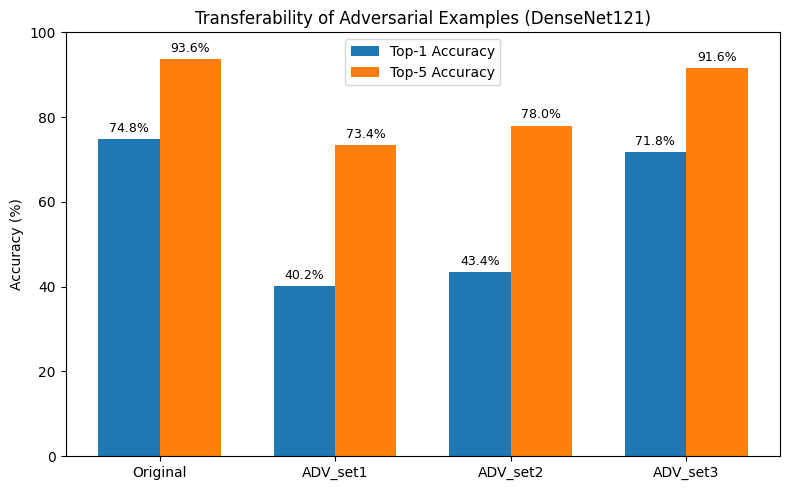

In [54]:
import matplotlib.pyplot as plt
import numpy as np


datasets = ['Original', 'ADV_set1', 'ADV_set2', 'ADV_set3']


top1_acc = [74.80, 40.20, 43.40, 71.80]
top5_acc = [93.60, 73.40, 78.00, 91.60]

x = np.arange(len(datasets))
width = 0.35


fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, top1_acc, width, label='Top-1 Accuracy')
bars2 = ax.bar(x + width/2, top5_acc, width, label='Top-5 Accuracy')


ax.set_ylabel('Accuracy (%)')
ax.set_title('Transferability of Adversarial Examples (DenseNet121)')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.set_ylim(0, 100)
ax.legend()


def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()
